## **Contexto**

Vamos trabalhar com os dados disponibilizados pela empresa Loggi, responsável pelo armazenamento e distribuição de produtos por todo Brasil. Os dados serão de Brasilia, onde serão avaliados os hubs de distribuição e pontos de entrega, para assim, estudar possíveis melhorias na logística de transporte da empresa.

## **Pacotes e bibliotecas**

In [ ]:
!pip3 install geopandas

import json
import pandas as pd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import numpy as np
import geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

## **Carregamento e exploração de dados**

In [ ]:
# Download de um arquivo JSON com nome deliveries.json

!wget -q https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json -O deliveries.json

In [ ]:
# Extraindo as informações de arquivo json e carregando em um dict
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

# Transformando o dict em um DataFrame pandas
deliveries_df = pd.DataFrame(data)

# Visualizando o DataFrame
deliveries_df.head()


,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Repare que a coluna 'origin' contém dados 'nested'(dado que não está pronto para ser utilizado, não é um dado direto) ou aninhados na estrutura do Json. Vamos normalizar a coluna usando a operação *flatten*(pega chave/valor e tenta contruir nova coluna): achatamento.

In [ ]:
# Normalizando a coluna origin
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
hub_origin_df

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145
...,...,...
194,-47.893662,-15.805118
195,-47.802665,-15.657014
196,-47.893662,-15.805118
197,-48.054989,-15.838145


Como se pode ver, foram criadas duas novas colunas: longitude e latitude. Com esses dados achatados, vamos juntá-los de volta ao DataFrame original e excluir a coluna anterior 'origin'.
Será utilizado o método *merge* para junção dos DataFrames e o how= inner, que combinará todos os dados presentes em todas as tabelas.

In [ ]:
# Mesclando os DataFrames com o método merge
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)

# Excluindo a coluna 'origin' original usando drop
deliveries_df = deliveries_df.drop("origin", axis=1)

# Selecionando e renomeando as novas colunas do DataFrame
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
deliveries_df

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."
...,...,...,...,...,...,...
194,cvrp-1-df-59,df-1,-47.893662,-15.805118,180,"[{'id': 'fc800db1942651f8195f870c5930ca26', 'p..."
195,cvrp-0-df-87,df-0,-47.802665,-15.657014,180,"[{'id': '3d50e820e1c16621e1fa19f1a7df0c56', 'p..."
196,cvrp-1-df-83,df-1,-47.893662,-15.805118,180,"[{'id': 'e6cffd090ce2a7bd0e0292f1ed9acd3', 'po..."
197,cvrp-2-df-7,df-2,-48.054989,-15.838145,180,"[{'id': '51b1354b02a20d919b83bb664ea4d845', 'p..."


Na coluna 'deliveries', contém uma lista de dados nested na estrutura do JSON. Para resolver essa questão, será utilizado o método *explode*, que transforma cada elemento da lista em uma linha. Após isso, será realizado o método *flatten*.

In [ ]:
# Separando as informações em linhas
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_exploded_df

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."
...,...
198,"{'id': '21693bf442ac5890adbdf2648c12881a', 'po..."
198,"{'id': '7aaa35088b37b6e542c4cd69663a7ebf', 'po..."
198,"{'id': '60c00d5390da4f28167439cd9c566703', 'po..."
198,"{'id': '51f456963785e7381243ff7baf7efd06', 'po..."


Após explodir os elementos da lista e transformar em linhas, será normalizada a estrutura(achatar) e extrair os elementos:

In [ ]:
# Preservou os índices e separou os valores
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record:
        record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record:
        record["id"])).rename(columns={"deliveries":"delivery_id"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record:
        record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record:
        record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_normalized_df

,delivery_size,delivery_id,delivery_lng,delivery_lat
0,9,313483a19d2f8d65cd5024c8d215cfbd,-48.116189,-15.848929
0,2,320c94b17aa685c939b3f3244c3099de,-48.118195,-15.850772
0,1,3663b42f4b8decb33059febaba46d5c8,-48.112483,-15.847871
0,2,e11ab58363c38d6abc90d5fba87b7d7,-48.118023,-15.846471
0,7,54cb45b7bbbd4e34e7150900f92d7f4b,-48.114898,-15.858055
...,...,...,...,...
198,8,21693bf442ac5890adbdf2648c12881a,-48.064269,-15.997694
198,4,7aaa35088b37b6e542c4cd69663a7ebf,-48.065176,-16.003597
198,9,60c00d5390da4f28167439cd9c566703,-48.065841,-16.003808
198,1,51f456963785e7381243ff7baf7efd06,-48.062327,-16.001568


Após isso, vamos combinar as novas colunas criadas ao conjunto de dados original:

In [ ]:
# Excluindo a coluna "deliveries" original
deliveries_df = deliveries_df.drop("deliveries", axis=1)

# Mesclando o novo DataFrame com o original, mantendo index
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df,
                         how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

deliveries_df

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_id,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,313483a19d2f8d65cd5024c8d215cfbd,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,320c94b17aa685c939b3f3244c3099de,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,3663b42f4b8decb33059febaba46d5c8,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,e11ab58363c38d6abc90d5fba87b7d7,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,54cb45b7bbbd4e34e7150900f92d7f4b,-48.114898,-15.858055
...,...,...,...,...,...,...,...,...,...
636144,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,8,21693bf442ac5890adbdf2648c12881a,-48.064269,-15.997694
636145,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,4,7aaa35088b37b6e542c4cd69663a7ebf,-48.065176,-16.003597
636146,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,9,60c00d5390da4f28167439cd9c566703,-48.065841,-16.003808
636147,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,1,51f456963785e7381243ff7baf7efd06,-48.062327,-16.001568


## **Manipulação**

O dado bruto é do tipo JSON com uma lista de instâncias de entregas. Cada instância representa um conjunto de entregas que devem ser realizadas pelos veículos do hub regional. Até o momento pegamos o dado bruto(JSON), transformamos em um DataFrame e normalizamos dados aninhados(utilizando o flatting e o explode).


Agora iremos **enriquecer** nosso dado gerando a **geocodificação reversa do hub**.
Isso nada mais é do que o processo que transforma uma coordenada geográfica (latitude, longitude) em um local em suas repectivas descrições textuais (endereço, nome, local, etc).



In [ ]:
#Gerando o DataFrame com as colunas de coordenadas
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by = 'region').reset_index(drop = True)
hub_df.head()


,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [ ]:
#Aplicando geocodificação nas coordenadas das 3 regiões e extraindo cidade e bairro
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745" )
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)
hub_df["coordinates"] = hub_df["hub_lat"].astype(str) + ", "
hub_df["coordinates"] = hub_df["coordinates"] + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


Note que o retorno recebeu uma coluna com nome de 'coodinates', com os valores de latitude e longitude juntos e a coluna 'geodata' com o endereço da coordenada.
Em seguida iremos normalizar o arquivo criando novas colunas:

In [ ]:
#Normalizando arquivo
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply( lambda data: data.raw ))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053343,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-127,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.053411,...,Distrito Federal,BR-DF,Região Centro-Oeste,70330-400,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000010,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


Agora iremos criar uma tabela, selecionando as colunas de interesse: 'adrees.town', 'adress.suburb' e 'adress.city'

In [ ]:
#Criando tabela e selecionando colunas'adrees.town', 'adress.suburb' e 'adress.city'
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb",
                                  "address.city"]]
hub_geodata_df.rename( columns={
    "address.town": "hub_town",
    "address.suburb" : "hub_suburb",
    "address.city": "hub_city" }, inplace=True)
hub_geodata_df["hub_city"] = np.where(
    hub_geodata_df["hub_city"].notna(),
    hub_geodata_df["hub_city"],
    hub_geodata_df["hub_town"] )
hub_geodata_df["hub_suburb"] = np.where(
    hub_geodata_df["hub_suburb"].notna(),
    hub_geodata_df["hub_suburb"],
    hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

<ipython-input-30-a96b7ea05ed3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename( columns={
<ipython-input-30-a96b7ea05ed3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df["hub_city"] = np.where(
<ipython-input-30-a96b7ea05ed3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geoda

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


O DataFrame hub_geodata_df com as informações de cidade e bairro é, então, combinado ao DataFrame principal deliveries_df enriquecendo assim o dado.

In [ ]:
#Juntando o DataFrame hub_geodata_df com DataFrame deliveries_df
hub_df = pd.merge( left=hub_df, right=hub_geodata_df, left_index=True, right_index=True )
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()


,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [ ]:
#Juntando ao DataFrame original
deliveries_df = pd.merge( left=deliveries_df, right=hub_df, how="inner", on="region" )
deliveries_df = deliveries_df[[ "name", "region", "hub_lng", "hub_lat",
                               "hub_city", "hub_suburb", "vehicle_capacity",
                                "delivery_size", "delivery_lng",
                                "delivery_lat" ]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


Em seguida, devemos fazer o mesmo processo de geocodificação reversa da entrega para a coluna delivery.
No caso desse projeto, devido ao elevado número de dados presentes da coluna delivery, os dados com a geolocalização podem ser obtidos pelo link abaixo:

In [ ]:
#Arquivo csv com geolocalização da coluna delivery
!wget -q -O deliveries-geodata.csv https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv

In [ ]:
#Geolocalização da coluna delivery
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv" )
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
#Juntando as colunas do DataFrame deliveries_geodata_df com o DataFrame original deliveries_df
deliveries_df = pd.merge( left=deliveries_df, right=deliveries_geodata_df
 [["delivery_city",
   "delivery_suburb" ]],
    how="inner", left_index=True, right_index=True )
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


Após exploração e manipulação de todos os dados, podemos ver abaixo a qualidade das informações obtidas, onde vemos pequena perda de dados em delivery_city e uma perda mais acentudada em delivery_suburb, com presença de valores nulos/faltantes.

In [ ]:
#Schema
deliveries_df.info()
deliveries_df.isna().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

## **Visualização**

Vamos utilizar o pacote Python GeopPandas para visualizar as coordenadas dos hubs e das entregas no mapa do Distrito Federal, segmentados pela região dos hubs.

In [64]:
#Download dos dados do mapa do Distrito Federal do site do IBGE no link
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [66]:
#Lendo a localização de Brasília
mapa = geopandas.read_file("distrito-federal.zip")
mapa = mapa.loc[[0]]
mapa.head()

,ID_ANTIGO,NOME,NOMEABREV,GEOMETRIAA,TIPOCEMITE,DENOMINACA,ID_PRODUTO,ID_ELEMENT,TX_COMENTA,geometry
0,3,None,None,Não,Desconhecido,None,None,None,None,"POLYGON Z ((-53.19467 -17.34088 0.00000, -53.1..."


**Mapa de hubs:** Criando o DataFrame geo_hub_df através do DataFrame deliveries_df. Note a nova coluna geometry:

In [67]:
#Criando DataFrame geo_hub_df
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates( ).reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame( hub_df, geometry=geopandas.points_from_xy
 ( hub_df["hub_lng"], hub_df["hub_lat"] ) )
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


**Mapa das entregas**:
Criando o DataFrame geo_deliveries_df através do DataFrame deliveries_df. Note a nova coluna geometry:

In [68]:
#Criando o DataFrame geo_deliveries_df
geo_deliveries_df = geopandas.GeoDataFrame( deliveries_df, geometry=geopandas
.points_from_xy( deliveries_df["delivery_lng"],
                deliveries_df["delivery_lat"] ) )
geo_deliveries_df .head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


## **Mapas**

<ipython-input-77-5b8c2a909fd0>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


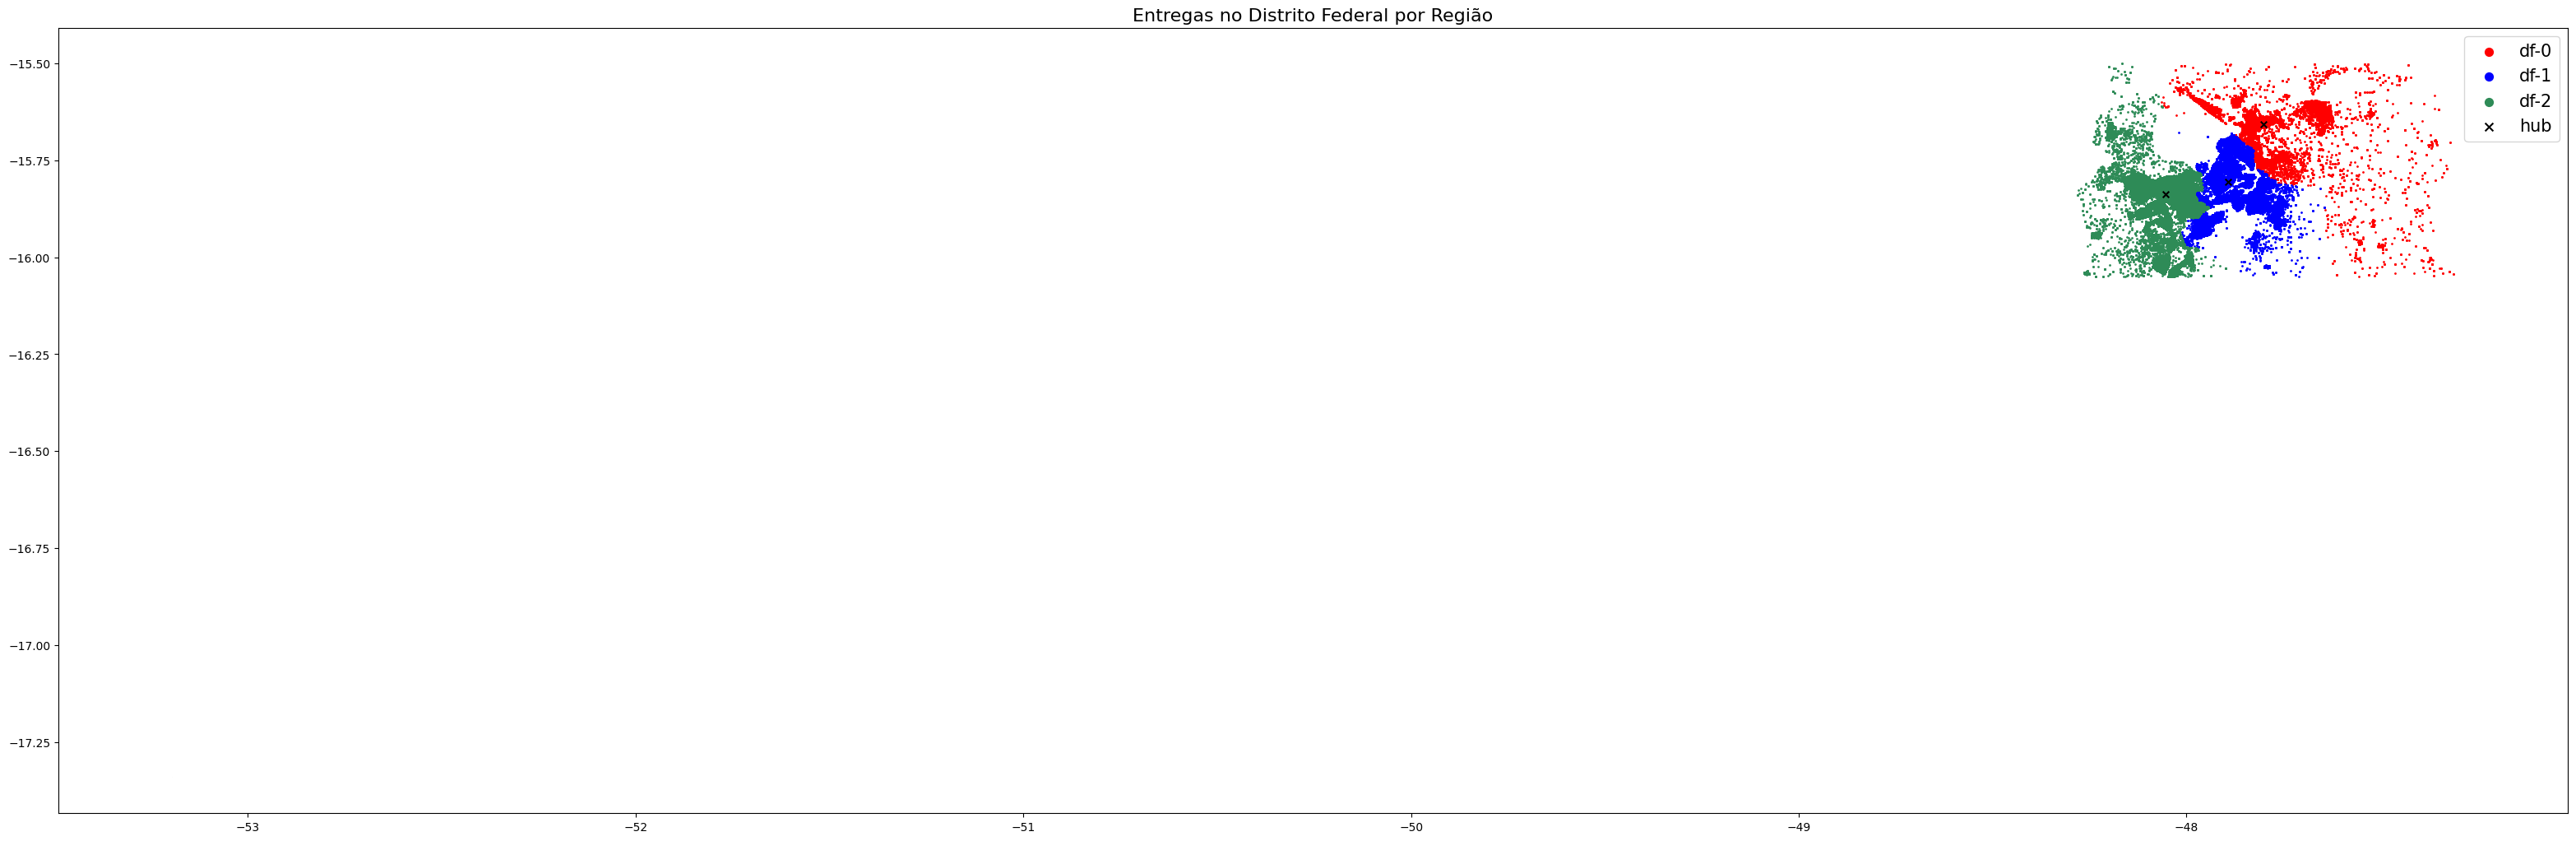

In [77]:
# cria o plot vazio, possibilitando colocar um gráfico em cima do outro
fig, ax = plt.subplots(figsize=(100/2.54, 100/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot( ax=ax, markersize=1, color="red", label="df-0" )
geo_deliveries_df.query("region == 'df-1'").plot( ax=ax, markersize=1, color="blue", label="df-1" )
geo_deliveries_df.query("region == 'df-2'").plot( ax=ax, markersize=1, color="seagreen", label="df-2" )

# plot dos hubs
geo_hub_df.plot( ax=ax, markersize=30, marker="x", color="black", label="hub" )

# plot da legenda
plt.title( "Entregas no Distrito Federal por Região" , fontdict={"fontsize": 16} )
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
  handle.set_sizes([50])

# **Insights**

**1.** As entregas estão corretamente alocadas aos seus respectivos hubs;

**2.** Os hubs das regiões 0 e 2 fazem entregas em locais distantes do centro e entre si, o que pode gerar um tempo e preço de entrega maior.

# Gráfico de entregas por região

In [70]:
#Gerando dados com proporção de entregas por região
data = pd.DataFrame(deliveries_df[['region',  'vehicle_capacity']].value_counts(normalize=True )).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

,region,vehicle_capacity,proportion
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


<ipython-input-75-995810bac232>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="proportion", errorbar=None, palette="pastel" )


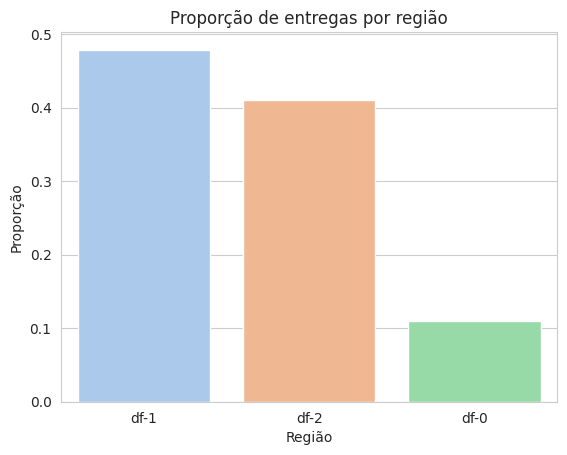

In [75]:
#Gráfico mostrando a proporção de entregas por região
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="proportion", errorbar=None, palette="pastel" )
  grafico.set( title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção' )

# **Insights**:
**1.** A distribuição das entregas está muito concentrada nos hubs das regiões 1 e 2, mas pouco no da região 0. Contudo a capacidade dos veículos é a mesma para todos os hubs, logo os veículos poderiam ser deslocados para as regiões de maior tráfego.